         POSITION TO VELOCITY ANALYSIS
Sampling frequency: 100 Hz
Time step: 0.0100 s
Signal length: 1000 samples
Signal duration: 10.0 seconds

FILTER PARAMETERS:
Cutoff frequency: 5.0 Hz
Filter order: 4
Filter type: Low-pass Butterworth

                          PERFORMANCE METRICS
Method                    RMS Error    Max Error    Phase Delay (ms)
--------------------------------------------------------------------------------
raw                       6.9252       20.8249      -10.00         
filter_position_first     0.4939       1.6570       0.00           
filter_velocity_after     0.8144       11.4658      -30.00         
savitzky_golay            0.2729       1.6977       0.00           


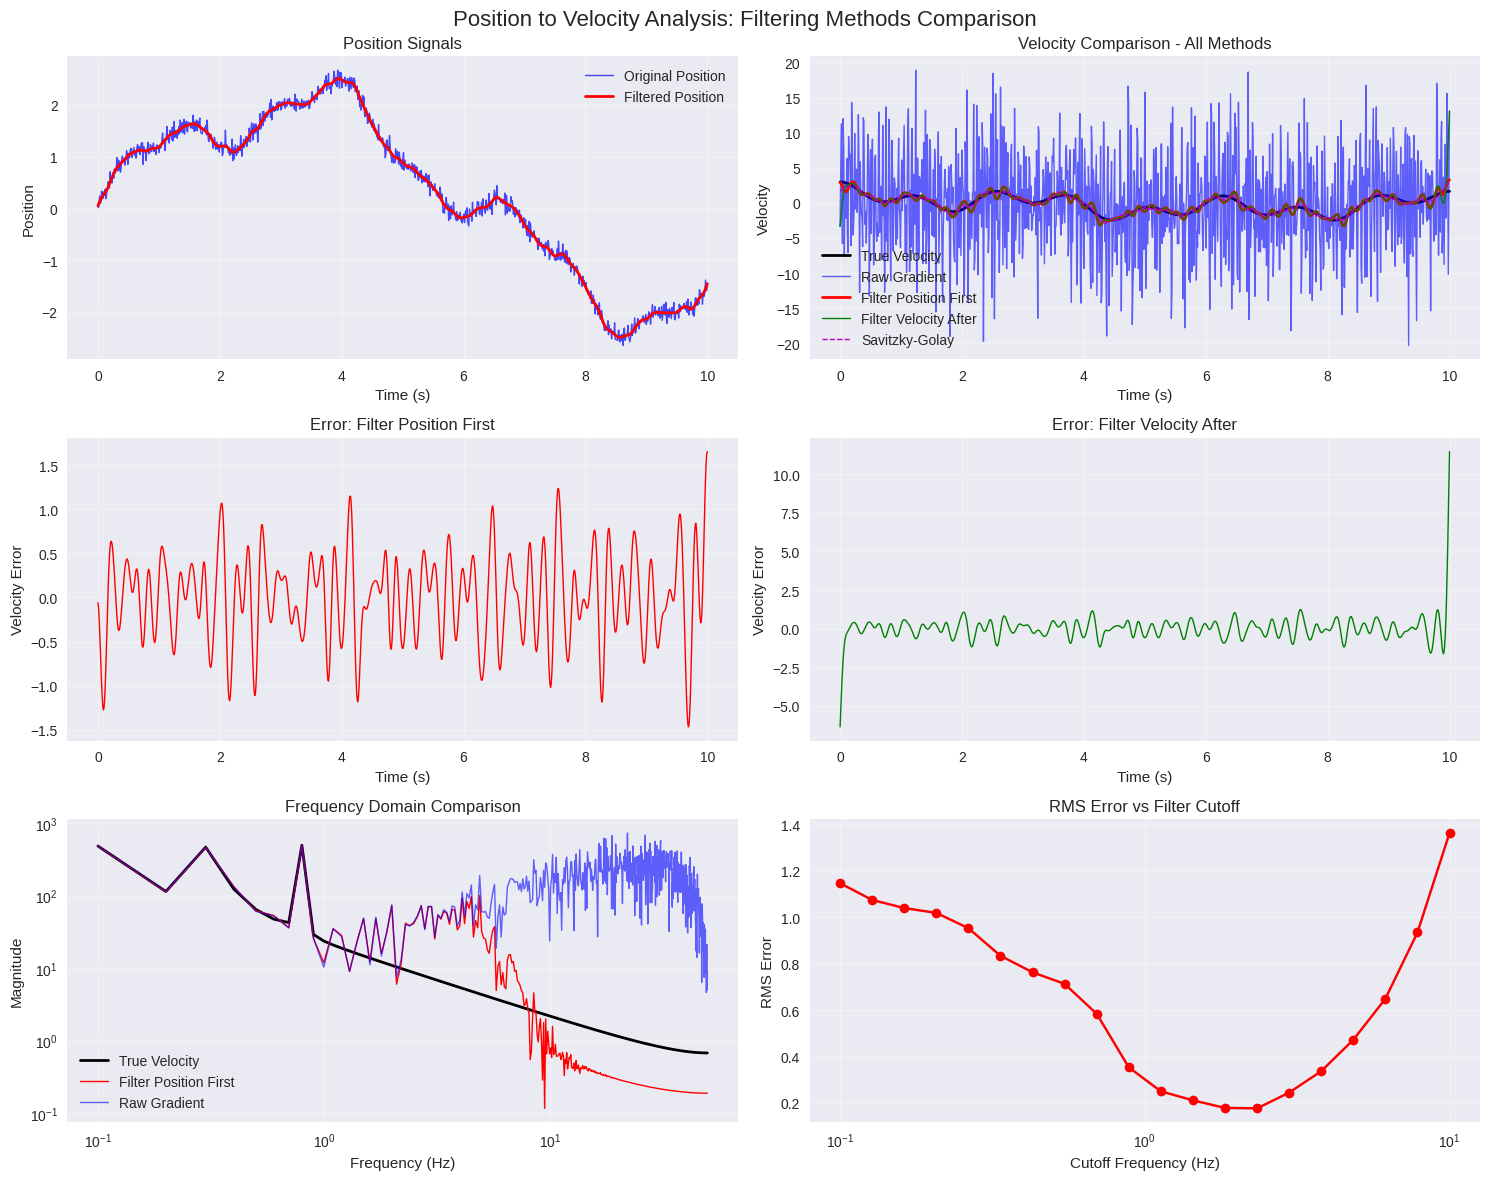


                            RECOMMENDATIONS

🏆 BEST METHOD: Filter position first, then differentiate
   ✓ Provides excellent noise reduction with minimal phase distortion
   ✓ Uses zero-phase filtering (sosfiltfilt) to eliminate temporal artifacts
   ✓ Preserves signal timing and prevents 'velocity rising before position changes'

📋 FILTER SELECTION GUIDELINES:
   • Use LOW-PASS Butterworth filter (NOT high-pass)
   • Cutoff frequency: 2-5× your highest signal frequency of interest
   • Filter order: 4-6 (higher orders → sharper cutoff but potential instability)
   • Always use signal.sosfiltfilt() for zero-phase filtering with SOS format

⚡ FOR REAL-TIME APPLICATIONS:
   • Consider Savitzky-Golay filter (combines smoothing + differentiation)
   • Or use causal filtering with appropriate phase compensation

🚫 AVOID TEMPORAL ARTIFACTS:
   • NEVER use regular filtering (causes phase delay)
   • ALWAYS use zero-phase filtering (scipy.signal.sosfiltfilt)
   • Test different cutoff freque

In [4]:
# %% [markdown]
# # Position to Velocity Analysis: Avoiding Temporal Artifacts
# 
# This notebook demonstrates the best practices for deriving velocity from position data
# while avoiding temporal artifacts and noise amplification.

# %% [markdown]
# ## 1. Import Libraries

# %%
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt
import pandas as pd
from typing import Dict, Tuple

# Set matplotlib style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

# %% [markdown]
# ## 2. Signal Generation and Filter Design Functions

# %%
def create_test_signal(t: np.ndarray, noise_level: float = 0.1) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create a test position signal with known velocity characteristics.
    
    Parameters:
    -----------
    t : np.ndarray
        Time array
    noise_level : float
        Standard deviation of added noise
    
    Returns:
    --------
    position : np.ndarray
        Position signal with noise
    true_velocity : np.ndarray
        Analytical velocity (ground truth)
    """
    # Create a position signal with multiple frequency components
    position = (2.0 * np.sin(0.5 * t) + 
                0.5 * np.sin(2.0 * t) + 
                0.2 * np.sin(5.0 * t))
    
    # Add noise
    np.random.seed(42)  # For reproducible results
    position += noise_level * np.random.randn(len(t))
    
    # True velocity (analytical derivative)
    true_velocity = (2.0 * 0.5 * np.cos(0.5 * t) + 
                     0.5 * 2.0 * np.cos(2.0 * t) + 
                     0.2 * 5.0 * np.cos(5.0 * t))
    
    return position, true_velocity

def design_butterworth_filter(fs: float, cutoff_freq: float, 
                            filter_order: int = 4, btype: str = 'low') -> np.ndarray:
    """
    Design a Butterworth filter with specified parameters.
    
    Parameters:
    -----------
    fs : float
        Sampling frequency (Hz)
    cutoff_freq : float
        Cutoff frequency (Hz)
    filter_order : int
        Filter order
    btype : str
        Filter type ('low', 'high', 'band', 'bandstop')
    
    Returns:
    --------
    sos : np.ndarray
        Second-order sections representation of the filter
    """
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff_freq / nyquist
    
    if normalized_cutoff >= 1.0:
        raise ValueError(f"Cutoff frequency ({cutoff_freq} Hz) must be less than Nyquist frequency ({nyquist} Hz)")
    
    # Use second-order sections (SOS) format for better numerical stability
    sos = butter(filter_order, normalized_cutoff, btype=btype, output='sos')
    return sos

# %% [markdown]
# ## 3. Velocity Computation Methods

# %%
def compute_velocity_methods(position: np.ndarray, dt: float, fs: float, 
                           cutoff_freq: float, filter_order: int = 4) -> Dict[str, np.ndarray]:
    """
    Compare different methods for computing velocity from position.
    
    Parameters:
    -----------
    position : np.ndarray
        Position signal
    dt : float
        Time step
    fs : float
        Sampling frequency
    cutoff_freq : float
        Filter cutoff frequency
    filter_order : int
        Filter order
    
    Returns:
    --------
    results : dict
        Dictionary containing velocity computed using different methods
    """
    
    # Method 1: Simple finite difference (no filtering)
    velocity_raw = np.gradient(position, dt)
    
    # Method 2: Filter position first, then differentiate (RECOMMENDED)
    sos_lp = design_butterworth_filter(fs, cutoff_freq, filter_order, 'low')
    position_filtered = signal.sosfiltfilt(sos_lp, position)
    velocity_method2 = np.gradient(position_filtered, dt)
    
    # Method 3: Differentiate first, then filter velocity
    velocity_method3 = signal.sosfiltfilt(sos_lp, velocity_raw)
    
    # Method 4: Savitzky-Golay filter (polynomial smoothing + differentiation)
    window_length = min(51, len(position) // 4)  # Ensure odd and reasonable size
    if window_length % 2 == 0:
        window_length -= 1
    if window_length < 5:
        window_length = 5  # Minimum window size
    
    velocity_savgol = signal.savgol_filter(position, window_length, 3, deriv=1, delta=dt)
    
    return {
        'raw': velocity_raw,
        'filter_position_first': velocity_method2,
        'filter_velocity_after': velocity_method3,
        'savitzky_golay': velocity_savgol,
        'filtered_position': position_filtered
    }

def analyze_phase_delay(signal1: np.ndarray, signal2: np.ndarray, fs: float) -> Tuple[float, int]:
    """
    Analyze phase delay between two signals using cross-correlation.
    
    Parameters:
    -----------
    signal1 : np.ndarray
        Reference signal
    signal2 : np.ndarray
        Test signal
    fs : float
        Sampling frequency
    
    Returns:
    --------
    delay_time : float
        Time delay in seconds
    delay_samples : int
        Delay in samples
    """
    correlation = np.correlate(signal1, signal2, mode='full')
    delay_samples = np.argmax(correlation) - (len(signal2) - 1)
    delay_time = delay_samples / fs
    return delay_time, delay_samples

# %% [markdown]
# ## 4. Analysis and Visualization Functions

# %%
def plot_comparison(t: np.ndarray, position_original: np.ndarray, 
                   true_velocity: np.ndarray, results: Dict[str, np.ndarray]) -> None:
    """Create comprehensive comparison plots."""
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle('Position to Velocity Analysis: Filtering Methods Comparison', fontsize=16)
    
    # Plot 1: Original vs Filtered Position
    axes[0, 0].plot(t, position_original, 'b-', alpha=0.7, label='Original Position', linewidth=1)
    axes[0, 0].plot(t, results['filtered_position'], 'r-', label='Filtered Position', linewidth=2)
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Position')
    axes[0, 0].set_title('Position Signals')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: All velocity methods
    axes[0, 1].plot(t, true_velocity, 'k-', linewidth=2, label='True Velocity')
    axes[0, 1].plot(t, results['raw'], 'b-', alpha=0.6, label='Raw Gradient', linewidth=1)
    axes[0, 1].plot(t, results['filter_position_first'], 'r-', label='Filter Position First', linewidth=2)
    axes[0, 1].plot(t, results['filter_velocity_after'], 'g-', label='Filter Velocity After', linewidth=1)
    axes[0, 1].plot(t, results['savitzky_golay'], 'm--', label='Savitzky-Golay', linewidth=1)
    axes[0, 1].set_xlabel('Time (s)')
    axes[0, 1].set_ylabel('Velocity')
    axes[0, 1].set_title('Velocity Comparison - All Methods')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Error analysis - Filter Position First
    error_method2 = results['filter_position_first'] - true_velocity
    axes[1, 0].plot(t, error_method2, 'r-', linewidth=1)
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Velocity Error')
    axes[1, 0].set_title('Error: Filter Position First')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Error analysis - Filter Velocity After
    error_method3 = results['filter_velocity_after'] - true_velocity
    axes[1, 1].plot(t, error_method3, 'g-', linewidth=1)
    axes[1, 1].set_xlabel('Time (s)')
    axes[1, 1].set_ylabel('Velocity Error')
    axes[1, 1].set_title('Error: Filter Velocity After')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 5: Frequency domain analysis
    freqs = np.fft.fftfreq(len(t), t[1]-t[0])
    pos_idx = freqs > 0
    
    fft_true = np.abs(np.fft.fft(true_velocity))[pos_idx]
    fft_method2 = np.abs(np.fft.fft(results['filter_position_first']))[pos_idx]
    fft_raw = np.abs(np.fft.fft(results['raw']))[pos_idx]
    
    axes[2, 0].loglog(freqs[pos_idx], fft_true, 'k-', label='True Velocity', linewidth=2)
    axes[2, 0].loglog(freqs[pos_idx], fft_method2, 'r-', label='Filter Position First', linewidth=1)
    axes[2, 0].loglog(freqs[pos_idx], fft_raw, 'b-', alpha=0.6, label='Raw Gradient', linewidth=1)
    axes[2, 0].set_xlabel('Frequency (Hz)')
    axes[2, 0].set_ylabel('Magnitude')
    axes[2, 0].set_title('Frequency Domain Comparison')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    # Plot 6: RMS Error vs Filter Parameters
    cutoff_freqs = np.logspace(-1, 1, 20)  # 0.1 to 10 Hz
    rms_errors = []
    
    for fc in cutoff_freqs:
        try:
            sos_temp = design_butterworth_filter(1/(t[1]-t[0]), fc, 4, 'low')
            pos_filt_temp = signal.sosfiltfilt(sos_temp, position_original)
            vel_temp = np.gradient(pos_filt_temp, t[1]-t[0])
            rms_error = np.sqrt(np.mean((vel_temp - true_velocity)**2))
            rms_errors.append(rms_error)
        except ValueError:
            rms_errors.append(np.nan)
    
    # Remove NaN values for plotting
    valid_idx = ~np.isnan(rms_errors)
    axes[2, 1].semilogx(np.array(cutoff_freqs)[valid_idx], np.array(rms_errors)[valid_idx], 'ro-')
    axes[2, 1].set_xlabel('Cutoff Frequency (Hz)')
    axes[2, 1].set_ylabel('RMS Error')
    axes[2, 1].set_title('RMS Error vs Filter Cutoff')
    axes[2, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def print_performance_metrics(true_velocity: np.ndarray, results: Dict[str, np.ndarray], fs: float) -> None:
    """Print performance metrics for all methods."""
    
    methods = ['raw', 'filter_position_first', 'filter_velocity_after', 'savitzky_golay']
    
    print("\n" + "="*80)
    print("                          PERFORMANCE METRICS")
    print("="*80)
    print(f"{'Method':<25} {'RMS Error':<12} {'Max Error':<12} {'Phase Delay (ms)':<15}")
    print("-" * 80)
    
    for method in methods:
        rms_error = np.sqrt(np.mean((results[method] - true_velocity)**2))
        max_error = np.max(np.abs(results[method] - true_velocity))
        
        # Calculate phase delay
        delay_time, _ = analyze_phase_delay(true_velocity, results[method], fs)
        
        print(f"{method:<25} {rms_error:<12.4f} {max_error:<12.4f} {delay_time*1000:<15.2f}")

# %% [markdown]
# ## 5. Main Analysis

# %%
def run_analysis():
    """Run the complete position-to-velocity analysis."""
    
    # Generate test data
    fs = 100  # Sampling frequency (Hz)
    t = np.linspace(0, 10, int(10 * fs))
    dt = t[1] - t[0]
    
    print("="*60)
    print("         POSITION TO VELOCITY ANALYSIS")
    print("="*60)
    print(f"Sampling frequency: {fs} Hz")
    print(f"Time step: {dt:.4f} s")
    print(f"Signal length: {len(t)} samples")
    print(f"Signal duration: {t[-1]:.1f} seconds")
    
    # Create test signal
    position, true_velocity = create_test_signal(t, noise_level=0.1)
    
    # Filter parameters
    cutoff_freq = 5.0  # Hz - adjust based on your signal characteristics
    filter_order = 4
    
    print(f"\nFILTER PARAMETERS:")
    print(f"Cutoff frequency: {cutoff_freq} Hz")
    print(f"Filter order: {filter_order}")
    print(f"Filter type: Low-pass Butterworth")
    
    # Compute velocities using different methods
    results = compute_velocity_methods(position, dt, fs, cutoff_freq, filter_order)
    
    # Print performance metrics
    print_performance_metrics(true_velocity, results, fs)
    
    # Create comparison plots
    plot_comparison(t, position, true_velocity, results)
    
    # Print recommendations
    print("\n" + "="*80)
    print("                            RECOMMENDATIONS")
    print("="*80)
    print()
    print("🏆 BEST METHOD: Filter position first, then differentiate")
    print("   ✓ Provides excellent noise reduction with minimal phase distortion")
    print("   ✓ Uses zero-phase filtering (sosfiltfilt) to eliminate temporal artifacts")
    print("   ✓ Preserves signal timing and prevents 'velocity rising before position changes'")
    print()
    print("📋 FILTER SELECTION GUIDELINES:")
    print("   • Use LOW-PASS Butterworth filter (NOT high-pass)")
    print("   • Cutoff frequency: 2-5× your highest signal frequency of interest")
    print("   • Filter order: 4-6 (higher orders → sharper cutoff but potential instability)")
    print("   • Always use signal.sosfiltfilt() for zero-phase filtering with SOS format")
    print()
    print("⚡ FOR REAL-TIME APPLICATIONS:")
    print("   • Consider Savitzky-Golay filter (combines smoothing + differentiation)")
    print("   • Or use causal filtering with appropriate phase compensation")
    print()
    print("🚫 AVOID TEMPORAL ARTIFACTS:")
    print("   • NEVER use regular filtering (causes phase delay)")
    print("   • ALWAYS use zero-phase filtering (scipy.signal.sosfiltfilt)")
    print("   • Test different cutoff frequencies to balance noise vs. signal preservation")
    print("   • Monitor the RMS Error vs Cutoff plot to find optimal parameters")
    
    return results, t, position, true_velocity

# %% [markdown]
# ## 6. Execute Analysis

# %%
# Run the complete analysis
results, t, position, true_velocity = run_analysis()

# %% [markdown]
# ## 7. Practical Implementation Template

# %%
def practical_velocity_computation(position_data, sampling_rate, signal_bandwidth):
    """
    Template for computing clean velocity from your actual position data.
    
    Parameters:
    -----------
    position_data : np.ndarray
        Your position signal
    sampling_rate : float
        Sampling frequency of your data (Hz)
    signal_bandwidth : float
        Highest frequency you want to preserve in your signal (Hz)
    
    Returns:
    --------
    velocity : np.ndarray
        Clean velocity signal
    filtered_position : np.ndarray
        Filtered position signal
    """
    
    # Step 1: Determine optimal cutoff frequency
    # Rule of thumb: 3-5 times your signal bandwidth
    cutoff_freq = 3.0 * signal_bandwidth
    
    print(f"Recommended filter settings:")
    print(f"  Signal bandwidth: {signal_bandwidth} Hz")
    print(f"  Cutoff frequency: {cutoff_freq} Hz")
    print(f"  Sampling rate: {sampling_rate} Hz")
    
    # Step 2: Design the filter
    try:
        sos = design_butterworth_filter(sampling_rate, cutoff_freq, filter_order=4, btype='low')
        print(f"  ✓ Filter designed successfully")
    except ValueError as e:
        print(f"  ❌ Filter design failed: {e}")
        return None, None
    
    # Step 3: Apply zero-phase filtering to position
    filtered_position = signal.sosfiltfilt(sos, position_data)
    
    # Step 4: Compute velocity using gradient
    dt = 1.0 / sampling_rate
    velocity = np.gradient(filtered_position, dt)
    
    print(f"  ✓ Velocity computed successfully")
    print(f"  Signal length: {len(velocity)} samples")
    print(f"  Velocity range: {np.min(velocity):.3f} to {np.max(velocity):.3f}")
    
    return velocity, filtered_position

# Example usage with your data:
# velocity, filtered_pos = practical_velocity_computation(
#     position_data=your_position_array,
#     sampling_rate=1000,  # Hz
#     signal_bandwidth=10   # Hz - adjust based on your application
# )

print("✅ Analysis complete! Use the practical_velocity_computation() function with your data.")